<a href="https://colab.research.google.com/github/Rajeeb321123/Deep-learning-tensorFlow-Journey/blob/master/07_milestone_project_1_food_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

See the annotation version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

### Check GPU

Google Colab offer free GPUs, however , not all of them are compatiable with mixed precision training. for into look ast supported hardware in https://www.tensorflow.org/guide/mixed_precision

Google Colab offers:
* K80 (not compatible)
*Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4  (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here https://developer.nvidia.com/cuda-gpus)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6bc077dc-5a76-47bd-ca87-424f0df8c946)


## Get helper functions

In past modules, we've created a bunch of hepler function to do small task required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-02 13:59:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-02 13:59:38 (78.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [4]:
# Get TensorFLow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all the available  datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [6]:
# Load in the data (take 5-6 minutes in Google Colab)
# some dataset are very large more than 100 Gb so downloading locally isnot good option
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],#some other dataset may have train, validation and test but for food101 there is only 2 given
                                             shuffle_files= True,# we want shuffling while downloading
                                             as_supervised = True, # data gets returned in tuple format: (data, label). for unsupervised we dont have this
                                             with_info = True, # download Meta download also i.e ds_info above
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteSOGLKB/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteSOGLKB/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

## Exploring the Food101 dataset from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names

In [8]:
# Get the class names
class_names = ds_info.features["label"].names # here name not class_names llike before
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Take one sample of the train data
# data is shuffled so we get new image every time
train_one_sample = train_data.take(1) # samples are in format (image_tesnor:element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), label:TensorSpec(shape=(), dtype=tf.int64, name=None) )
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about training sample
for image, label in train_one_sample: # two value in list (image, label)
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)
  # seems like labels arenot one hot encoded i.e [0,0,0,...1,0,0..] instead of 93 or 74 or .. in target class
  # image shape is different every time like here 512, 512 but before we had 512, 288 : we need same image shape for all


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 77,
  Class name (str form): pork_chop
  


In [12]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:

# What are the min and max values of our image tensor
tf.reduce_min(image), tf.reduce_max(image)
# seems like our data is between 0 and 255 but we want data between 0 and 1
# and dtype is uint8 which isnot best for training

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot the image from TensorFow dataset

In [15]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=77>

(-0.5, 511.5, 511.5, -0.5)

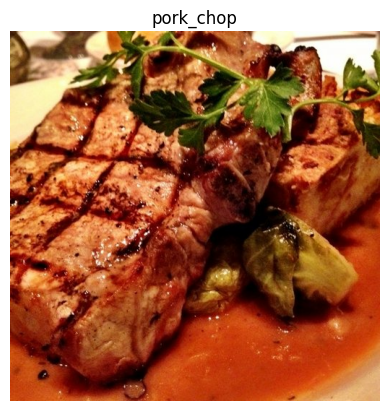

In [16]:

# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify label is associated with right image
plt.axis(False)

## Create preprocessing functions for our data

Neural Network perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, we'll often have to write preprocessing functions and map it to our data.

what we know about our data:
* In `uint8` dataType
* Comprised of all different size tensor (different sized images)
* Not scaled ( the pixed value are between 0 and 255)

What we know models like:
* Data in `float32` dype (or for mixed precision `float16` and `float32`)
* for batches, TensorFlow like all of the tensors with a batch to be the same size
* Scaled (values between 0 and 1) also called normalized tensors generally perform better.

With these point in mind, we've go a few things we can tackle with a preprocessing function.

Since we're using EfficientNetBx pretrained model from tf.keras.applications we don't nee to rescale our data (these architecture have rescaling built-in).

This means our functions need to:
1. Reshape our images to all the same size.
2. Convert the dtype of our image tensor from `uint8` to `float32`.

In [17]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> reshapes
  image to [img_shape, img_shape, color_channels] eg: (224,224,3)
  """

  image = tf.image.resize(image, [img_shape, img_shape]) #reshape target image
  # image = image/255. # scaled image value but we don't need to do for EFficientnetBx
  return tf.cast(image, tf.float32),  label # retrun tuple of (float32_image, label)

In [18]:
# Preprocess a single sample image and check the output
preprocessed_img = preprocess_img(image, label)[0]

print(f"Image before preprocessing: \n {image[:2]}..., \n {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \n {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")
# still value between 0 ang 255 as we dont need it fro EfficientnetBx
# but look at shape: (224, 224, 3) and dtype: float32

Image before preprocessing: 
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]..., 
 (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing: 
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]..., 
 (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

* must -> For more resources on this , I'd highly recommend the following guide: https://www.tensorflow.org/guide/data_performance

* must -> also read all part of Data input pipline from above link.
* must -> for future, our own data.

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [21]:
# for train_data
# Map preprocessing function to training data ( and parallelize it)
# datatype will be changed into float32 from uint8 automatically
# preprocess_img is function we created above: remember preprocess_img need (data, label) as arg and in  train_data.map... train data is also in that format so it wont be a problem
# Autontune: tensorflow automatically tune no of process it uses as it run or find no of cpu and use it all. Colab uses 2 cpu: utilize all compute all we have to speed up the thing
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
# shuffle it again just for precaution
# shuffle 1000 sample at a time
# ideally buffer_size=len(train_data)for best  but our computer may lack resource so set a fix large number
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


# Similar for test data
# Map preprocessing function to test data
# batch of 32
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# we can also .cache(): it store mapped data in ram and while training faster loading but only if data is smaller that if can be stored in RAM



In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFLow, map this preprocessing function (`preprocess_img`) accross our training dataset, then shuffle a number of elements and then batch them together and finally make sure we prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch".

> `prefetch`: while one batch is computed on another batch is prepreapared.

> `for other dataset format than image`: compare how it relate to this to load - https://www.tensorflow.org/tutorials/load_data/csv

## Create modelling callbacks

for large dataset like, training could take long time, so callbacks to track logs, checkpoints is important.

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.


In [23]:
# Create tensorboard callback (import from helper_function.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckPoint callback to save a model's progreass during training.
# we save weights only here but model can be also be saved but it will be slower
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # what to monitor val_loss, val_acc,...etch
                                                      save_best_only=True, # update the model only better val_acc : best parctise it set it to True
                                                      save_weights_only=True,# for faster
                                                      verbose=0) # don't print whether  or not model is being saved

## Setup mixed precision training

* `must very important`: First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision.
* Mixed precision utilizes a combination of Float32 and float16 data types to speed up model performance.
* If we use float16 if possible for that layer there be more space in our CPU and GPU for other tasks for faster operation.
* Though calcuation will be done in float16 if possible but storage is done in float 32 for stability. so it can used in compilation properly, output of our model that feeds into loss_Function need to be float32.

`Extra` Single precsion floatin point: https://en.wikipedia.org/wiki/Single-precision_floating-point_format and half precision: https://en.wikipedia.org/wiki/Half-precision_floating-point_format for insight how computer store number.



In [24]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
# use float 16 if possible to speed up
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision: float32 is default but for mixed precision utilize both float 32 and float 16

In [25]:
mixed_precision.global_policy() # for large model improvement will be amazing.

<Policy "mixed_float16">

## Build Feature Extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name = "input_layer")

# NOTE: EFficientNetBx models have rescaling built-in but if our model doesn't we you can have layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)

# separate the Dense so we will be able to pass dtype = tf.float32 in outputs
x = layers.Dense(len(class_names))(x) # How many output neuron we want: equal to no of class_names = 101
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [27]:
label # not one hot encoded , in integer form, so we need to use sparse Categorical entorpy below in compile

<tf.Tensor: shape=(), dtype=int64, numpy=77>

In [28]:
# Compile teh model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype poliies (are we using mixed precision?)

In [30]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Going through the above  we see:
* `layer.name`: the human readable name of particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, weights are frozen).
* `layer.dtype`: the datatype a layer store it's variable in
* `layer.dtype_policy`: the data type policy a layer computes on its variable with

In [31]:
# Check the dtype_policy of layers in EfficentBnet0 in our model which is in index 1 of our model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
  # turn those layer that should or can use mixed float 16 but for some layer we need float 32 even inside Efficientnet. automatically done easy

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [32]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple ouptut layers with base layers frozen).
2. Fine tune some of the frozen layer afterwards.

In [34]:
# Fit teh feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, # we used best practices like data input pipelining previously already.
                                                     epochs=3,
                                                     steps_per_epoch = (len(train_data)),
                                                     validation_data=test_data, #only difference between test and train data while input pipeline was shuffle
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101"),
                                                                model_checkpoint])
#This is would have been extremely time consuming without AUTOTUNE ins Data input pipelining and prefetch using poweer of all available Cpu and GPU.
# Autotune: hepls to find most efficient way to load images even though it is 70000 images.

Saving TensorBoard log files to: training_logs/efficientnetb0_101/20240402-142526
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7191 - accuracy: 0.5825

2368/2368 [==============================] - 206s 81ms/step - loss: 1.7191 - accuracy: 0.5825 - val_loss: 1.1230 - val_accuracy: 0.6973
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2003 - accuracy: 0.6884

2368/2368 [==============================] - 166s 69ms/step - loss: 1.2003 - accuracy: 0.6884 - val_loss: 1.0271 - val_accuracy: 0.7211
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0538 - accuracy: 0.7239

2368/2368 [==============================] - 194s 81ms/step - loss: 1.0538 - accuracy: 0.7239 - val_loss: 0.9861 - val_accuracy: 0.7304


## off to you...

W've covered a lot of ground so far but since this is a milestone project, it's time for me to takeover.

More specifically, you're challenge is to complete the Template version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the **TEMPPLATE** notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

In [35]:
# Evaluate on whole dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 54s 69ms/step - loss: 0.9973 - accuracy: 0.7293


[0.9973270297050476, 0.7293069362640381]

In [36]:
# Import series of hepler functionsj in our note book
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

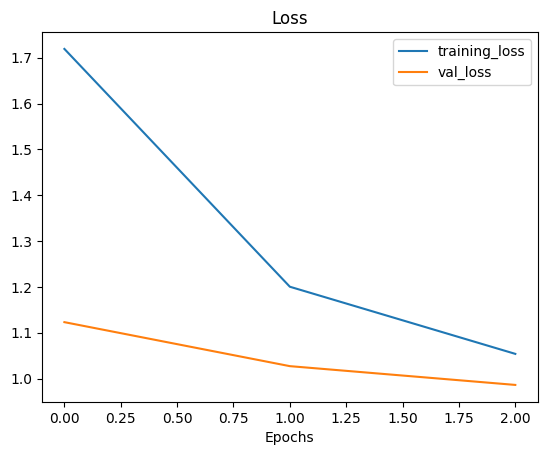

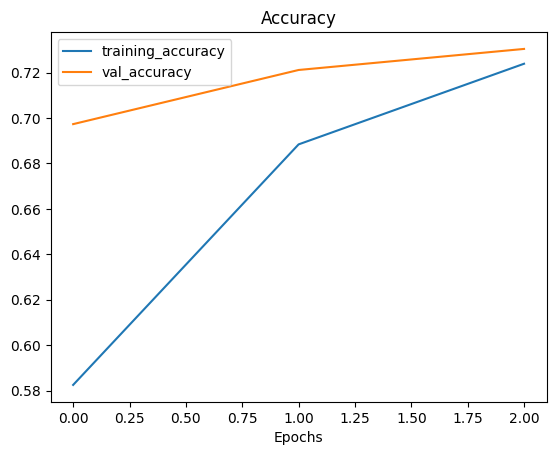

In [37]:
plot_loss_curves(history_101_food_classes_feature_extract)

## Saving the model drive

In [ ]:
# Save our fine-tunning model
model.save("drive/MyDrive/tensorflow_course/07_101_food_classes__efficientnetb0_feature_extract_finetuned_model_mixed_precision")